In [3]:
from numba import cuda
import numpy as np

from math import exp

In [4]:
@cuda.jit
def g_gpu(sigma, k_size, kernel):
    n = k_size // 2
    m = k_size // 2
    x = cuda.threadIdx.x
    y = cuda.threadIdx.y
    
    kernel[x,y]  = exp(-((x-m)**2 + (y-n)**2 / (2*sigma**2)))

In [26]:
sigma = 3
k_size = 3
kernel = np.zeros((k_size, k_size), np.float32)
d_kernel = cuda.to_device(kernel)

In [27]:
@cuda.jit
def convolve(result, mask, img):
    i ,j = cuda.grid(2)
    img_rows, img_cols = img.shape
    if(i >= img_rows) or (j>=img_cols):
        return
    
    d_rows = mask.shape[0] // 2
    d_cols = mask.shape[1] // 2
    
    s =0 
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            i_k = i - k + d_rows
            j_l = j - l + d_cols
            if(i_k >= 0) and (i_k < img_rows) and (j_l >=0) and (j_l <= img_cols):
                s += mask[k,l] * img[i_k, j_l]
    result[i, j] = s
    
    

In [28]:
from PIL import Image, ImageOps

img = np.asarray(ImageOps.grayscale(Image.open('/kaggle/input/trojanusc/usctrojan.jpeg')))
d_img = cuda.to_device(img)

d_res = cuda.device_array_like(img)
g_gpu[(1,), (k_size, k_size)](sigma, k_size, d_kernel)

blockdim = (32,32)
griddim = (img.shape[0] // blockdim[0] + 1,img.shape[1] // blockdim[1] + 1)


0.27121502500000005


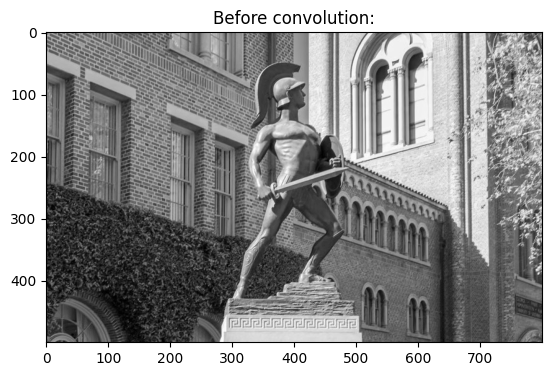

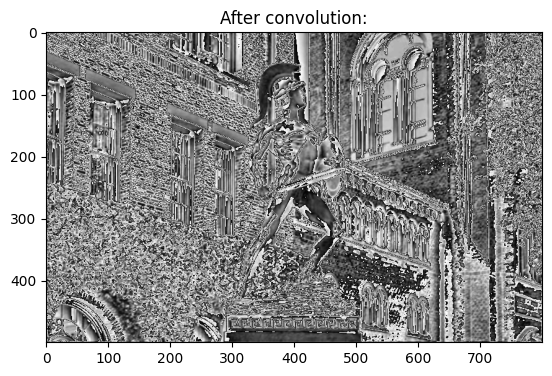

In [29]:
import time
start = time.process_time()
convolve[griddim, blockdim](d_res, d_kernel, d_img)
print (time.process_time() - start)
result = d_res.copy_to_host()

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(img, cmap='gray')
plt.title("Before convolution:")
plt.figure()
plt.imshow(result, cmap='gray')
plt.title("After convolution:") 
plt.show()